**Accessing Data**

Data is stored in a mongodb on sissy-serv-03. This is a searchable database that we can access from anywhere. In this tutorial we'll see how to connect to the database and find a run that we've previously done.


In [1]:
# See which catalogs are configured on this host

import databroker
list(databroker.catalog)


['sissy2']

If you're running this script locally (not on jupyter hub) and none are shown you'll need to set one up. See [mongoDB Config](http://sissy-pi-01/dokuwiki/doku.php?id=experiment_control:mongo_db)


In [2]:
# Connect to the sissy2 catalog
db = databroker.catalog["sissy2"]

**The most recent run**

We can access the most recent run using an index -1


In [3]:
most_recent_run = db[-1]

We can read the data into an [xarray](http://xarray.pydata.org/en/stable/)

In [4]:
most_recent_run.primary.read()

<xarray.Dataset>
Dimensions:                    (time: 10)
Coordinates:
  * time                       (time) float64 1.614e+09 1.614e+09 ... 1.614e+09
Data variables:
    sissy2_keithley0_readback  (time) float64 1.089e-15 1.162e-15 ... 1.076e-15

**UID**

every run in bluesky creates a globally unique uid. You can find it at the start and end of a scan. We can use this uid to get a run from a database. 

In [5]:
run = db["3f8ce47"]

In [6]:
run.primary.read()

<xarray.Dataset>
Dimensions:         (time: 5)
Coordinates:
  * time            (time) float64 1.611e+09 1.611e+09 ... 1.611e+09 1.611e+09
Data variables:
    det             (time) float64 0.6065 0.8825 1.0 0.8825 0.6065
    motor           (time) float64 -1.0 -0.5 0.0 0.5 1.0
    motor_setpoint  (time) float64 -1.0 -0.5 0.0 0.5 1.0

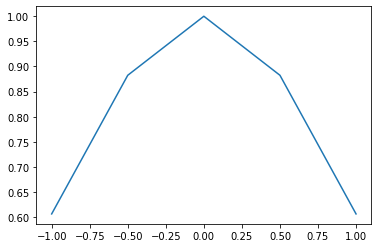

In [8]:
data=run.primary.read()

import matplotlib.pyplot as plt

plt.plot(data["motor"],data["det"]) # Note that this looses lots of the context given in the xarray


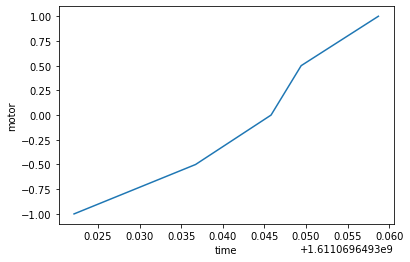

In [12]:
# We can also use the plot method for the xarray dataArray
data.motor.plot()


There is also some support inside the xarray dataset class to plot scatter plots


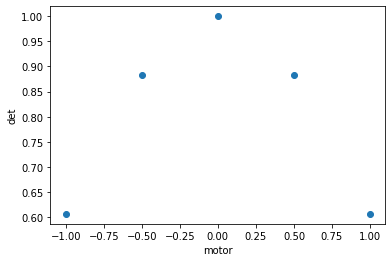

In [14]:
data.plot.scatter(x="motor", y="det")

**Accessing Metadata**

When we run a scan we add meta data to it to make it easy to find later and give additional information about the scan. We can take baseline readings beforehand, and there is a wealth of information stored by bluesky from each run.

In [15]:
run.baseline.read()

<xarray.Dataset>
Dimensions:          (time: 2)
Coordinates:
  * time             (time) float64 1.611e+09 1.611e+09
Data variables:
    det3             (time) float64 1.213 1.213
    motor1           (time) int64 0 0
    motor1_setpoint  (time) int64 0 0
    det1             (time) float64 5.0 5.0
    det2             (time) float64 1.765 1.765
    motor2           (time) int64 0 0
    motor2_setpoint  (time) int64 0 0

Bluesky also make many other documents with information about the scan [read about them here](https://nsls-ii.github.io/bluesky/documents.html)
    

In [18]:
run.metadata['start']

Start({'detectors': ['det'],
 'hints': {'dimensions': [[['motor'], 'primary']]},
 'motors': ['motor'],
 'num_intervals': 4,
 'num_points': 5,
 'plan_args': {'args': ["SynAxis(prefix='', name='motor', "
                        "read_attrs=['readback', 'setpoint'], "
                        "configuration_attrs=['velocity', 'acceleration'])",
                        -1,
                        1],
               'detectors': ["SynGauss(prefix='', name='det', "
                             "read_attrs=['val'], configuration_attrs=['Imax', "
                             "'center', 'sigma', 'noise', "
                             "'noise_multiplier'])"],
               'num': 5,
               'per_step': 'None'},
 'plan_name': 'scan',
 'plan_pattern': 'inner_product',
 'plan_pattern_args': {'args': ["SynAxis(prefix='', name='motor', "
                                "read_attrs=['readback', 'setpoint'], "
                                "configuration_attrs=['velocity', "
                 

In [19]:
run.metadata['stop']

Stop({'exit_status': 'success',
 'num_events': {'baseline': 2, 'primary': 5},
 'reason': '',
 'run_start': '3f8ce47c-d6de-4671-bafa-f5aa1b8ced25',
 'time': 1611069649.3706937,
 'uid': '3238d8d6-c566-46f5-823a-b20698237f88'})

In [20]:
run.primary.metadata

{'start': {'uid': '3f8ce47c-d6de-4671-bafa-f5aa1b8ced25',
  'time': 1611069649.3033385,
  'versions': {'ophyd': '1.6.0', 'bluesky': '1.6.7'},
  'scan_id': 2,
  'plan_type': 'generator',
  'plan_name': 'scan',
  'detectors': ['det'],
  'motors': ['motor'],
  'num_points': 5,
  'num_intervals': 4,
  'plan_args': {'detectors': ["SynGauss(prefix='', name='det', read_attrs=['val'], configuration_attrs=['Imax', 'center', 'sigma', 'noise', 'noise_multiplier'])"],
   'num': 5,
   'args': ["SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=['velocity', 'acceleration'])",
    -1,
    1],
   'per_step': 'None'},
  'hints': {'dimensions': [[['motor'], 'primary']]},
  'plan_pattern': 'inner_product',
  'plan_pattern_module': 'bluesky.plan_patterns',
  'plan_pattern_args': {'num': 5,
   'args': ["SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=['velocity', 'acceleration'])",
    -1,
    1]}},
 'stop': {'run_start': '3f

**Searching The Catalog**

The mongoDB catalog gives us powerful search capabilities. When we perform a scan we can add metadata to it like

```RE(scan(dets, motor, -1, 1, 10), sample_id='A', operator= 'Will')```

Later if we want to search for all the runs with sample_id='A' we can use: 



In [25]:
# Connect to the sissy2 catalog
db = databroker.catalog["sissy2"]

results = db.search({"sample_id":"A"})


We can see how many results are in our search


In [26]:
len(results)

3

If we wanted the most recent run in the search we can use

In [27]:
run = results[-1]

If you want to itterate through results, use this. Here we are just printing the uid's but you could also process the data here

In [28]:
for uid, run in results.items():
    print(uid)

ad697e51-9c59-4146-8e92-2d667185798a
79343cc2-a28c-4da6-8179-28cc36d8ea02
bfbbeffa-93c9-4482-b2bd-e2ff07fdce57


You can read more about the databroker and catalogs [here](https://blueskyproject.io/databroker/docs-rewrite-draft/tutorials/search-and-lookup.html)